In [587]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [588]:
df = pd.read_csv("a1_data.csv") 

In [589]:
df.head()

,30,64,1,1.1
0,30.0,62.0,3.0,1
1,30.0,65.0,0.0,1
2,31.0,59.0,2.0,1
3,31.0,65.0,4.0,1
4,33.0,58.0,10.0,1


In [590]:
# formating

In [591]:
new_row = {'30':30, '64':64,'1':1.1, "1.1":1} # add 1st row to the end
df = df.append(new_row, ignore_index=True)
df.rename(columns={"30": 'Age', "64": 'Year_of_Operation', "1":"nodes_detected", "1.1":"Surv_status"}, inplace=True) # rename cols
df["Surv_status"] = df["Surv_status"].apply(lambda x : 1 if x == 1 else -1) # convert to more appropriate values 1 is surv, -1 if death

C:\Users\La_Admin\AppData\Local\Temp\ipykernel_23952\4039083124.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [592]:
df.head()


,Age,Year_of_Operation,nodes_detected,Surv_status
0,30.0,62.0,3.0,1
1,30.0,65.0,0.0,1
2,31.0,59.0,2.0,1
3,31.0,65.0,4.0,1
4,33.0,58.0,10.0,1


In [593]:
np.count_nonzero(df.isnull()) # we have a little amount of nulls

5

In [594]:
df = df.dropna() # just drop them

In [595]:
df.reset_index(inplace = True, drop = True)

In [596]:
df.shape

(302, 4)

<AxesSubplot:>

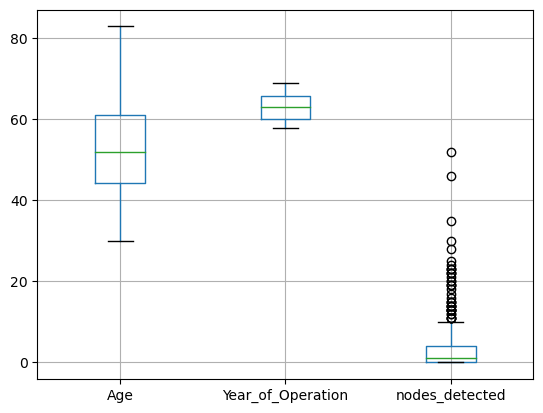

In [597]:
df.iloc[:, 0:df.shape[1]-1].boxplot() # it seems that nodes_detected has a lot of outliers, we will handle this soon

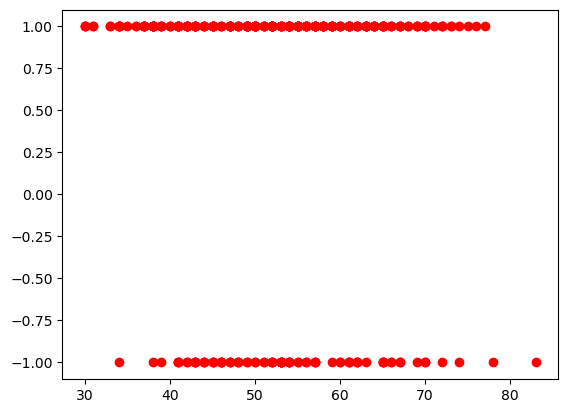

In [598]:
plt.scatter(df["Age"], df["Surv_status"], color = "red") # assumption : older is the patient - more likely he\she will be dead


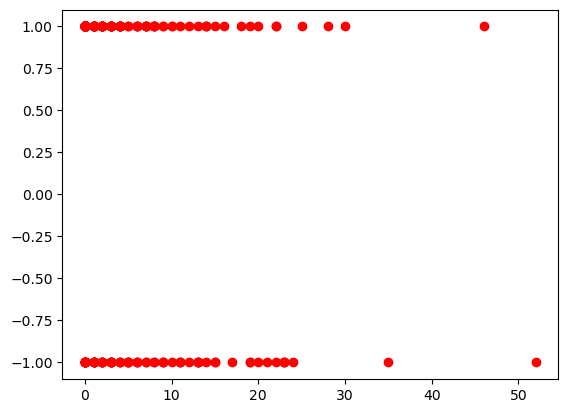

In [599]:
plt.scatter(df["nodes_detected"], df["Surv_status"], color = "red") # same assumption as with age

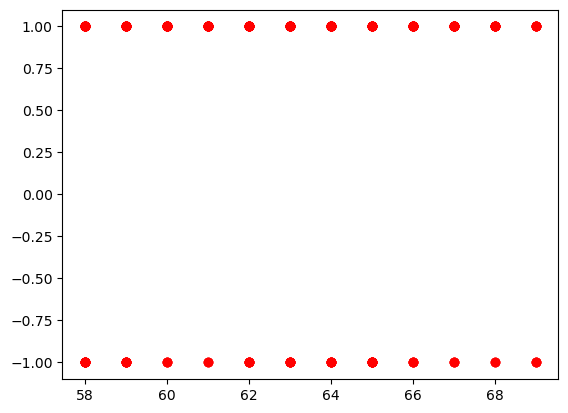

In [600]:
plt.scatter(df["Year_of_Operation"], df["Surv_status"], color = "red") # no effect at all!

<AxesSubplot:>

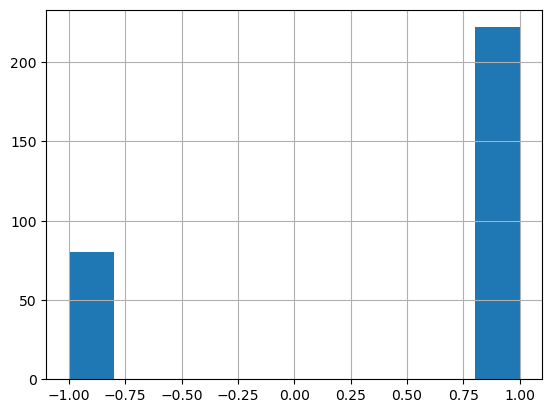

In [601]:
df["Surv_status"].hist() # our dataset is unabalnced
# hence, the model may be good at predicting ones (patient surv), but on the other hand it will make a lot of mistakes predicting -1 (deaths)
# since the model will not be able to prorely learn how to distinguish death from the survival

In [602]:
df.corr() # as we see, year of operation has almost 0 correlation with dependent variable, meaning that changes in this variable
# will not cause any chagnges in the dependent variable (surv_stat)
# also, negative correlation for the rest of the variables, as expected (despite it is slight correlation)

,Age,Year_of_Operation,nodes_detected,Surv_status
Age,1.000000,0.091882,-0.067058,-0.070500
Year_of_Operation,0.091882,1.000000,-0.006916,0.012328
nodes_detected,-0.067058,-0.006916,1.000000,-0.282551
Surv_status,-0.070500,0.012328,-0.282551,1.000000


In [603]:
df.drop("Year_of_Operation", axis = 1, inplace = True) # we will drop this column

In [604]:
df.head()

,Age,nodes_detected,Surv_status
0,30.0,3.0,1
1,30.0,0.0,1
2,31.0,2.0,1
3,31.0,4.0,1
4,33.0,10.0,1


In [605]:
num_pipeline = Pipeline([ # scale the variables to get better results afterwards, sicne age and nodes_detected are scaled very differently
    ('std_scaler', StandardScaler())
])

X = df.iloc[:, 0:df.shape[1]-1] # except the target variable
X_t = num_pipeline.fit_transform(X)
new = pd.DataFrame(X_t, columns = ["Age","nodes_detected"])
t = df["Surv_status"]
new.insert(2, "Surv_status", df["Surv_status"], True)
df = new 

In [606]:
df.info() # all good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             302 non-null    float64
 1   nodes_detected  302 non-null    float64
 2   Surv_status     302 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 7.2 KB


In [607]:
df.head()

,Age,nodes_detected,Surv_status
0,-2.119417,-0.144691,1
1,-2.119417,-0.560718,1
2,-2.025922,-0.283367,1
3,-2.025922,-0.006015,1
4,-1.838933,0.826039,1


<AxesSubplot:>

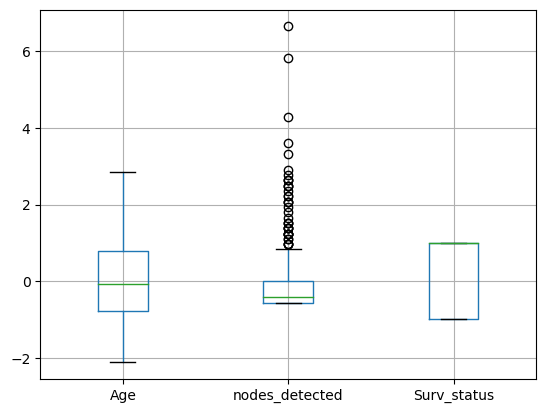

In [608]:
df.boxplot() # outliers for nodes_detected

In [609]:
def no_outliers(data): # delete the outliers from nodes_detected column
    global df
    Q3 = np.quantile(data, 0.75)
    Q1 = np.quantile(data, 0.25) 
    IQR = Q3 - Q1 
    lower_range = Q1 - 1.5 * IQR 
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data if ((x > lower_range) & (x < upper_range))]
    filtered_data = df.loc[data.isin(outlier_free_list)]
    df = filtered_data # update our dataframe

<AxesSubplot:>

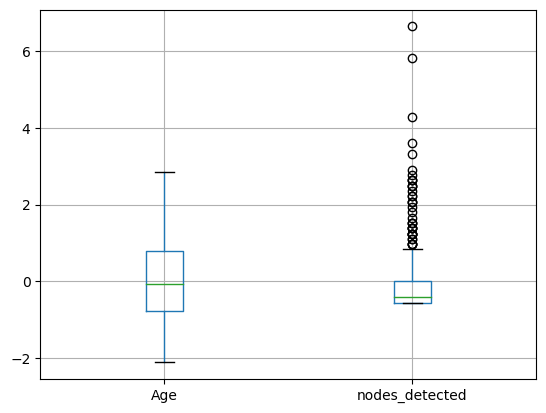

In [610]:
df.iloc[:, 0:df.shape[1]-1].boxplot() # before

In [611]:
no_outliers(df["nodes_detected"])

<AxesSubplot:>

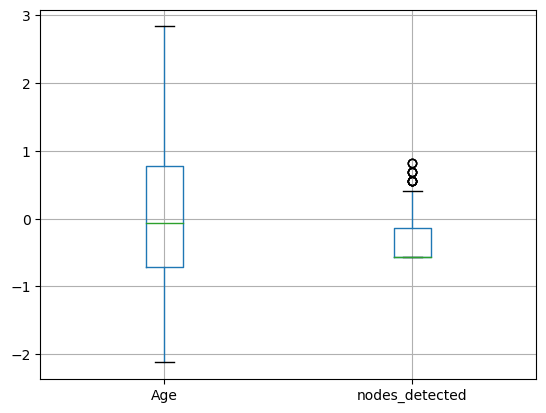

In [612]:
df.iloc[:, 0:df.shape[1]-1].boxplot() # after

In [613]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:2], df["Surv_status"], test_size=0.2, random_state=42) # split

In [614]:
model =  LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [615]:
model.score(X_train,y_train) # accuracy for the train set,  it is 81%

0.8133971291866029

In [616]:
confusion_matrix(y_train, model.predict(X_train)).ravel() # tn, fp, fn, tp. as we see all -1's were misclassified 

array([  0,  39,   0, 170], dtype=int64)

In [617]:
model =  SVC()
model.fit(X_train,y_train)
model.score(X_train,y_train) # here same mean accuracy

0.8133971291866029

In [618]:
confusion_matrix(y_train, model.predict(X_train)).ravel() # tn, fp, fn, tp, and the same conf matrix

array([  0,  39,   0, 170], dtype=int64)

In [619]:
model =  SGDClassifier() # try simple SGD class
model.fit(X_train,y_train)
model.score(X_train,y_train) # a bit lowe mean accuracy

0.7942583732057417

In [620]:
confusion_matrix(y_train, model.predict(X_train)).ravel() # tn, fp, fn, tp. here we also had a mistakes on predcitn the 1's

array([  5,  34,   9, 161], dtype=int64)

In [621]:
# it is complicated to say - what model is better here, becasue all of them performed bad on the training set (mistakes)
# Hence, we will perform cross vald here, since we have a small dataset
# we will use various metrics to estimate the perfromance

In [622]:
def analyze_class_with_metrics(model,x,y,folds = 5):
    d = x
    scores = cross_val_score(model, d, y,scoring="accuracy", cv=folds).mean()
    scores1 = cross_val_score(model, d, y,scoring="precision", cv=folds).mean()
    scores2 = cross_val_score(model, d, y,scoring="recall", cv=folds).mean()
    scores3 = cross_val_score(model, d, y,scoring="f1", cv=folds).mean()
    scores4 = cross_val_score(model, d, y,scoring="roc_auc", cv=folds).mean()
    print(f"mean accuracy: {scores}\n mean precision: {scores1}\n mean recall: {scores2}\n mean f1 score: {scores3}\n mean area under the ROC curve: {scores4}")
    return 

In [623]:
model1 =  LogisticRegression() # all 3 models we tried before
model2 = SVC()
model3 = SGDClassifier()

In [624]:
d = X_train.iloc[:, 0:X_train.shape[1]-1]

In [625]:
analyze_class_with_metrics(model1, d, y_train) # log regression

mean accuracy: 0.8134727061556329
 mean precision: 0.8134727061556329
 mean recall: 1.0
 mean f1 score: 0.8971228070175439
 mean area under the ROC curve: 0.4373424369747899


In [626]:
analyze_class_with_metrics(model2, d, y_train) # support vec mac

mean accuracy: 0.8134727061556329
 mean precision: 0.8134727061556329
 mean recall: 1.0
 mean f1 score: 0.8971228070175439
 mean area under the ROC curve: 0.4832457983193278


In [627]:
analyze_class_with_metrics(model3, d, y_train) # simple classifier optimized with SGD

mean accuracy: 0.7462253193960511
 mean precision: 0.8108394108394108
 mean recall: 0.9117647058823529
 mean f1 score: 0.856140350877193
 mean area under the ROC curve: 0.46927521008403356


In [628]:
# analyze metrics

In [629]:
# we will not pay a lot of attention on the recall, since its obvious that most of the time it will be high
# because our train dataset consists mostly of 1's rahther that -1's, so the model will learn how to classify a 1 pretty well
# however SGD classifier has a relatively low recall -722% (in comparison to the others). so, in this case with this model only 72% of surv (1's) were classified as 1, on average
# other 2 models have very high recall

In [630]:
# SGD (shortly - bad model, we not only made a mistakes on -1's but also on predciting 1's)

In [631]:
# as we see, recall for the SGD classifier is a bit lower in comparison to the others. It means that not only this model made a 
# expected mistaked clasyfing a -1 (because our dataset is unbalanced), but also model made some mistaked classyfing a 1! 
# in our case only 72% of them (1's) were classified correcly. This "tough" theresehold increases percision a bit
# since we will be more sure saying 1, but it decreases our recall as well, because of such theresehold a lot of 1's are missclasified
# as a result of "bad" recall accuracy is also not that high - again because we made mistakes with the 1's.
# f1 score, that combines both recall and percison will be lower for this model as well
# accuracy is affected not only by false positives here, but also bu false negatives (when 1's were classified as -1's), hence it will be lower here
# because other model did not make such mistakes (FN's).
# finally, area under the roc curve is close to the 0.5, which is bad! in fact it shows us the following:
# if we sort our values in dataframe by age and nodes detected, we would like to see all -1's (our assumption: more age and nodes - death) 
# and then all 1's continuously. But in our case, we will see mostly a random distribution of our 1's and -1's as a result of sort, or ranking in the other words
# meaning that we cannot really distinguish - is it a 1 or -1 only based on the age and nodes_detected! We cannot say that thershold of age, say, 80 and nodes detected = 30,
# (big values) will guarantee us to allocate all deaths (-1). In fact, a lot of 1's are also that old and have a lot of nodes detected.
# so, ranking based on these 2 values makes no sense here, and our classification is close to be random (50%/50%)
#

In [632]:
# SVC

In [633]:
# this model performed better than SGD classifier. All measurments are higher! Note that percision is almost the same here.
# it because its not affected by false negatives (mistakes on the class 1). It also means, that we still make a mistakes
# on -1's, actually all 3 models constantly made a mistakes classyfying -1's, but SVC did a good job classyfing 1's - recall of 100%!
# all of our surv patients were labled correctly. In the other words, despite we are good at predicting 1's, we will not be that good
# with the -1's, and our percision tells us that! We always had some decent amount of false postives (-1's predicted as 1's),
# hence that affected our percision. Acually, this is the problem we talked about before - unbalanced dataset! 
# Because we have small number of -1's, our models will not be able to learn - how allocate them from wast majority of 1's. 
# Finally, area under the ROC curve is not good - decreasment of 3%. even less sense of ranking here.

In [634]:
# log regression

In [635]:
# alsmot the same performance as it was with SVC.
# one difference - even lower area under the ROC curve - only 43%!
# still, good on classyfying the 1's, very bad at classfyyinhg the -1's. 

In [636]:
# I decided to chose the SVC model as our final estimator. all of our models were bad, frankly saying.
# but SVC is the golden middle here - better recall and f1 score than for the SGD classifier and bigger area under the ROC curve
# than log regression.
 

In [637]:
model = SVC() # final model
model.fit(X_train, y_train) # train

SVC()

In [638]:
def analyze_test(model,x,y): # get our measures
    y_hats = model.predict(x)
    acc = accuracy_score(y,y_hats)
    perc = precision_score(y,y_hats)
    f1 = f1_score(y,y_hats)
    roc = roc_auc_score(y,y_hats)
    recall = recall_score(y,y_hats)
    print(f"accuracy: {acc}\n percision: {perc}\n recall: {recall}\n f1 score: {f1}\n area under the roc curve: {roc}")

In [639]:
analyze_test(model, X_test,y_test)

accuracy: 0.660377358490566
 percision: 0.660377358490566
 recall: 1.0
 f1 score: 0.7954545454545454
 area under the roc curve: 0.5


In [640]:
# recall is good- 100%! all 1's were labled correctly. But still, we are very bad at classyfing -1's. A lot of false positives
# affect our percision badly. Area under the curve is 0.5% - tells us that if we rank our data by age and nodes_detected, the
# distr of our Surv rate will be random. We cannot say that some values for age and nodes_detected will help us to distinguish 1's from -1's

In [641]:
df.insert(3, "Predictions", (model.predict(df.iloc[:, 0:2])), True)

In [642]:
df.head()

,Age,nodes_detected,Surv_status,Predictions
0,-2.119417,-0.144691,1,1
1,-2.119417,-0.560718,1,1
2,-2.025922,-0.283367,1,1
3,-2.025922,-0.006015,1,1
4,-1.838933,0.826039,1,1


In [643]:
df.loc[df["Surv_status"] == -1]

,Age,nodes_detected,Surv_status,Predictions
6,-1.745439,-0.560718,-1,1
30,-1.277966,-0.560718,-1,1
39,-1.090976,-0.560718,-1,1
40,-1.090976,-0.560718,-1,1
48,-0.997482,-0.422043,-1,1
49,-0.997482,-0.560718,-1,1
58,-0.903987,-0.283367,-1,1
59,-0.903987,-0.560718,-1,1
60,-0.903987,-0.560718,-1,1
68,-0.810493,0.271336,-1,1


In [644]:
# yes, as we can see - all -1's were labled inccorectly! Our model was not able to learn properly - how to distinguish a -1 from 1!
# to fix this we simply need more data towards the deaths of our patients (class -1)